# Correlation studies between Aggregated variables
This plots will shown the correlation (or lack of) between QUEUE time, NETWORK rate and the aggregated_fts values, LINK rate, Number of files in queue per activity
* import libraries
* create the RSE to site mapping
* get the data
* plot plot plot

In [30]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq, curve_fit

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

In [ ]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [ ]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
data['N_RATE_MB'] = data['N_RATE']/(1024*1024)
data['SIZE_MB'] = data['SIZE']/(1024*1024)

In [21]:
src = 'IN2P3-CC'
dst = 'CERN-PROD'
####################
# LINK RATES
######
index_list = []
for i in range(0, DELTA+1):
    index_list.append('fts-aggregates_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%-m'))
indexes = ','.join(index_list)
print (index_list)

period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["src", "dest", "timestamp","rate"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "src" : "%s"%(src) }},
                {"term" : { "dest" : "%s"%(dst) }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
l_rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    #if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        l_rates.append([r['src']+'__'+r['dest'],r['timestamp']/1000,r['rate']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
l_rates = pd.DataFrame(l_rates, columns=['LINK', 'TS', 'RATE'], index=tsindex)

##############
# SRC RATES
#
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["name", "timestamp", "ingress", "egress", "incoming", "outcoming"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "name" : "%s"%(src) }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
cern_rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    #not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        cern_rates.append([r['name'],r['timestamp']/1000,r['ingress'], r['egress'], r['incoming'],r['outcoming']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        break
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
cern_rates = pd.DataFrame(cern_rates, columns=['NAME', 'TS', 'ING','EGR', 'INC', 'OUTC'], index=tsindex)
#####################
# DST RATES
#####
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["name", "timestamp","ingress", "egress", "incoming", "outcoming"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "name" : "%s"%(dst) }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
bnl_rates = []
tsindex2 = []
for res in scroll:
    r = res['_source']
    #if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        bnl_rates.append([r['name'],r['timestamp']/1000,r['ingress'], r['egress'], r['incoming'],r['outcoming']])
        tsindex2.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
bnl_rates = pd.DataFrame(bnl_rates, columns=['NAME', 'TS', 'ING','EGR', 'INC', 'OUTC'], index=tsindex2)


['fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2']
Reading took 0.38666319847106934 seconds.
14400
Reading took 1.1648006439208984 seconds.
14400
Reading took 0.3764939308166504 seconds.
14400


In [22]:
activities = [ "Data Consolidation",
               #"Data Brokering",
               #"Data Rebalancing",
               "Express",
               #"Functional Test",
               "Production Input",
               "Production Output",
               #"Recovery",
               #"Staging",
               #"T0 Export",
               #"T0 Tape",
               "User Subscriptions",
             ]
ts = time.time()
cut = data.where(data.LINK == src+'__'+dst+'__'+activities[0]).dropna()
print(len(cut))
for act in activities[1:]:
    subcut = data.where(data.LINK == src+'__'+dst+'__'+act).dropna()
    print(len(subcut))
    cut = pd.concat([cut,subcut])
link_rate = []
c_ing = []
c_egr = []
c_inc = []
c_out =[]
b_ing = []
b_egr = []
b_inc = []
b_out =[]
for t in cut.itertuples():
    t_index = (t.STARTED - (t.STARTED%60))-60  # link rate at the previous minute
    #print (rates.iloc(t_index))
    link_rate.append(l_rates.loc[t_index].RATE)
    c_ing.append(cern_rates.loc[t_index].ING)
    c_egr.append(cern_rates.loc[t_index].EGR)
    c_inc.append(cern_rates.loc[t_index].INC)
    c_out.append(cern_rates.loc[t_index].OUTC)
    b_ing.append(bnl_rates.loc[t_index].ING)
    b_egr.append(bnl_rates.loc[t_index].EGR)
    b_inc.append(bnl_rates.loc[t_index].INC)
    b_out.append(bnl_rates.loc[t_index].OUTC)

cut['LINK_RATE'] = link_rate
cut['DST_ING'] = c_ing
cut['DST_EGR'] = c_egr
cut['DST_INC'] = c_inc
cut['DST_OUT'] = c_out
cut['SRC_ING'] = b_ing
cut['SRC_EGR'] = b_egr
cut['SRC_INC'] = b_inc
cut['SRC_OUT'] = b_out
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
print('Done in %d sec.'%(time.time()-ts))

11115
5274
50510
4789
32130
Done in 350 sec.


### Correlation between the variables
In all the cases, all the activities are taking into account unless it specified.

In [ ]:

plt.plot(cut.CERN_INC, cut.CERN_ING,'.', label='incoming vs ingress')
plt.plot(cut.CERN_OUT, cut.CERN_EGR,'.', label='outcoming vs egress')
plt.title('# of incoming/outcoming transfers vs ingress/egress rates %s --> %s'%(src, dst))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print('This is something I was expecting')
plt.show()

In [ ]:
plt.plot(cut.BNL_INC, cut.BNL_ING,'.', label='incoming vs ingress')
plt.plot(cut.BNL_OUT, cut.BNL_EGR,'.', label='outcoming vs egress')
plt.title('# ofincoming/outcoming transfers vs ingress/egress rates BNL-ATLAS (<-- CERN-PROD)')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print('This is something I was expecting')
plt.show()

Correlation values for CERN --> BNL (Prod Input only)

In [12]:
cut_pi = cut.where(cut.LINK == '%s__%s__Production Input'%(src, dst)).dropna()
print(len(cut_pi))
cut_pi.corr().N_RATE.sort_values()

50510


DST_INC     -0.070311
DST_OUT     -0.064269
SRC_INC     -0.063469
DST_ING     -0.061589
SRC_EGR     -0.033348
Q_TIME      -0.020558
T_TIME      -0.014249
SRC_OUT     -0.009119
STARTED      0.088283
ENDED        0.088318
SUBMITTED    0.088385
SRC_ING      0.160038
DST_EGR      0.171613
LINK_RATE    0.188663
SIZE         0.571462
SIZE_MB      0.571462
N_RATE       1.000000
N_RATE_MB    1.000000
Name: N_RATE, dtype: float64

Correlation values for CERN --> BNL (all important activities)

In [13]:
print (len(cut))
cut.corr().N_RATE.sort_values()

103818


DST_OUT     -0.150777
DST_ING     -0.126706
SRC_EGR     -0.068321
DST_INC     -0.065509
SRC_OUT     -0.036508
SRC_INC      0.076079
SUBMITTED    0.076563
STARTED      0.083752
ENDED        0.083803
Q_TIME       0.419323
T_TIME       0.420514
DST_EGR      0.470249
SRC_ING      0.524233
LINK_RATE    0.566274
SIZE         0.722486
SIZE_MB      0.722486
N_RATE       1.000000
N_RATE_MB    1.000000
Name: N_RATE, dtype: float64

## Transfer rates vs Other variables

In [ ]:
plt.plot(cut.N_RATE_MB, cut.LINK_RATE,'.', label='all activities')
plt.plot(cut_pi.N_RATE_MB, cut_pi.LINK_RATE,'.', label='only prod input')
plt.title('Transfer vs Link rates %s --> %s'%(src, dst))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('link rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#plt.plot(cut.N_RATE, cut.CERN_ING,'.', alpha=0.5, label='CERN ingress rate')
#plt.plot(cut.N_RATE, cut.CERN_EGR,'.', alpha=0.5, label='CERN ingress rate')
plt.plot(cut.N_RATE_MB, cut.SRC_ING,'.', alpha=0.5, label='ingress rate')
plt.plot(cut.N_RATE_MB, cut.SRC_EGR,'.', alpha=0.5, label='egress rate')
plt.title('Transfer Rate vs ingress/eggress rates for %s --> %s'%(src, dst))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(cut.N_RATE_MB, cut.DST_ING,'.', alpha=0.5, label='ingress rate')
plt.plot(cut.N_RATE_MB, cut.DST_EGR,'.', alpha=0.5, label='egress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Transfer rate vs ingress/egress rates for %s --> %s'%(src, dst))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
#plt.plot(cut.N_RATE_MB, cut.CERN_ING,'.', alpha=0.5, label='CERN ingress rate')
#plt.plot(cut.N_RATE_MB, cut.CERN_EGR,'.', alpha=0.5, label='CERN egress rate')
plt.plot(cut.N_RATE_MB, cut.BNL_INC,'.', alpha=0.5, label='BNL incoming rate')
plt.plot(cut.N_RATE_MB, cut.BNL_OUT,'.', alpha=0.5, label='BNL outcoming rate')
plt.title('Transfer rate vs BNL incoming/outcoming transfers for CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(cut.N_RATE_MB, cut.CERN_INC,'.', alpha=0.5, label='CERN incoming')
plt.plot(cut.N_RATE_MB, cut.CERN_OUT,'.', alpha=0.5, label='CERN outcoming')
#plt.plot(cut.N_RATE_MB, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Transfer rate vs CERN incoming/outcoming transfers for %s --> %s'%(src, dst))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
x = cut.where(cut.BNL_INC>0).dropna()
y = x.where(x.N_RATE_MB>0).dropna()

heatmap, xedges, yedges = np.histogram2d(np.log(y.N_RATE_MB), np.log(x.BNL_INC), bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='coolwarm')
plt.gcf().set_size_inches(17, 8)
plt.colorbar()
plt.show()

In [ ]:
x = cut.where(cut.CERN_INC>0).dropna()
y = x.where(x.N_RATE_MB>0).dropna()

heatmap, xedges, yedges = np.histogram2d(np.log(y.N_RATE_MB), np.log(x.CERN_INC), bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='coolwarm',)
plt.gcf().set_size_inches(17, 8)
plt.colorbar()
plt.show()

In [ ]:
plt.plot(cut.N_RATE_MB, cut.SIZE_MB,'.', alpha=0.5, label='transf vs size')
plt.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', alpha=0.5, label='size vs transf')
plt.plot(cut_pi.SIZE_MB, cut_pi.N_RATE_MB,'.', alpha=0.5, label='size vs transf (prod input only)')
#plt.plot(cut.N_RATE, cut.CERN_EGR,'.', alpha=0.5, label='CERN egress rate')
#plt.plot(cut.N_RATE, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Size/Transfer rate relation for BNL-ATLAS --> CERN-PROD')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()
print(len(cut))
print(len(cut_pi))

In [65]:
def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model

def f( x, rate, overhead, diskrw_limit):
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return model

def ff(x, p):
    return f(x, *p)

def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1)
    print(pfit)
    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    print(pcov)
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

cut2 = cut.where(cut.N_RATE != np.inf).dropna()
print(len(cut.where(cut.N_RATE != np.inf).dropna()))
print(len(cut))
vars = [cut2.N_RATE.mean(), .1, 100.0]
#out = leastsq(objective, vars, args=(cut2.SIZE, cut2.N_RATE),full_output=1)
pfit, perr = fit_leastsq(vars, cut2.SIZE, cut2.N_RATE, ff)
 
print(pfit, perr)
rate = pfit[0]
overhead = pfit[1]
diskrw = pfit[2]
cut2['NLFIT'] = cut2.SIZE/((cut2.SIZE/rate)+overhead)
cut2['NLFIT'][cut2['NLFIT']>diskrw]=diskrw


103728
103818
[  4.10797542e+07   3.01072648e+00   3.93262560e+07]
[[  8.85200049e+09   1.34367855e+03  -0.00000000e+00]
 [  1.34367855e+03   6.94142699e-04  -0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   8.71831805e+10]]
[  4.10797542e+07   3.01072648e+00   3.93262560e+07] [  9.40850705e+04   2.63465880e-02   2.95267981e+05]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAE:4.29 R²:0.70


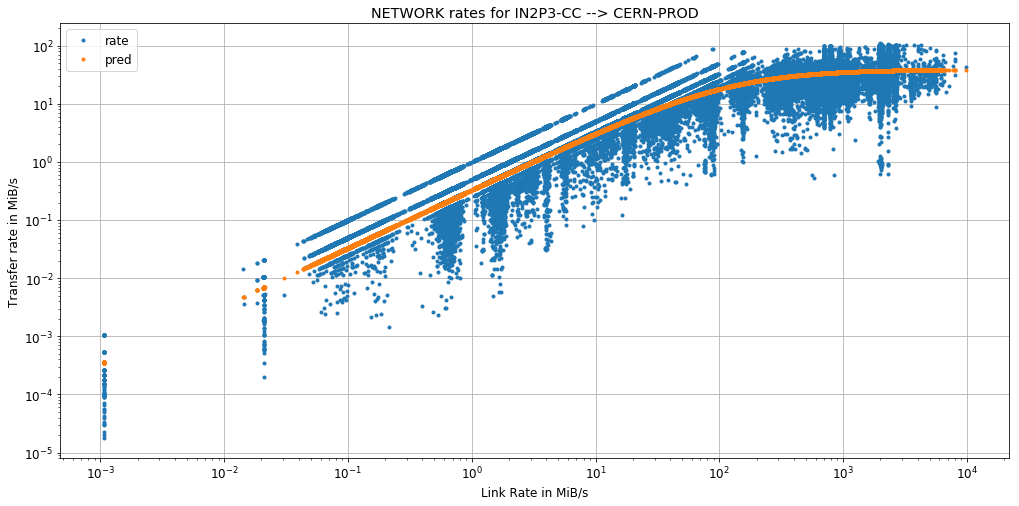

In [64]:
plt.plot(cut2.SIZE_MB, cut2.N_RATE_MB,'.', label='rate')
plt.plot(cut2.SIZE_MB, cut2.NLFIT/(1024*1024),'.', label='pred')
plt.title('NETWORK rates for %s --> %s'%(src, dst))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Link Rate in MiB/s')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print ('MAE:%.02f R²:%.02f'%(mae(cut2.N_RATE_MB, cut2.NLFIT/(1024*1024)),r2(cut2.N_RATE, cut2.NLFIT)))
plt.show()

In [ ]:
fplot = plt.figure().gca(projection='3d')
#plt.plot(cut[['SIZE_MB']],cut.N_TIME/(1024*1024),'.', label='real rate')
#plt.plot(cut[['SIZE_MB']],cut.LINK_RATE,'.', label='real rate')
fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_RATE_MB, marker='.',alpha=0.2, label='real')
fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.NLFIT/(1024*1024), marker='^',alpha=0.9, label='real')
#fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED,marker='^',alpha=0.5, label='pred')
#fplot.scatter(cut.SIZE_MB,cut.LINK_RATE,cut.N_PRED_FI,marker='s',alpha=0.5, label='pred')
fplot.set_xlabel('SIZE in MiB')
fplot.set_ylabel('link rate in MiB/s')
fplot.set_zlabel('transfer rate in MiB/s')
#fplot.set_xscale('log')
#fplot.set_yscale('log')
#fplot.set_zscale('log')
#plt.plot(cut[['SIZE_MB']],cut.N_TIME/(1024*1024),cut.N_PRED_FI,zdir='z',fmt='.', label='pred rate with fit intercept',alpha=0.5)

#n_mae_fi = mae(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
#n_mse_fi = mse(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
#n_r2_fi = r2(cut.N_TIME/(1024*1024), cut.N_PRED_FI)
#n_mae = mae(cut.N_TIME/(1024*1024), cut.N_PRED)
#n_mse = mse(cut.N_TIME/(1024*1024), cut.N_PRED)
#n_r2 = r2(cut.N_TIME/(1024*1024), cut.N_PRED)
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')# (R² no fit inter:%0.02f | R² fit inter:%0.02f)'%(n_r2_fi,n_r2))
#plt.yscale('log')
#plt.xscale('log')
#plt.xlabel('File size in MiB')
#plt.ylabel('Transfer rate in MiB/s')
fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.legend()
#plt.grid()

fplot.view_init(10,9)
plt.draw()
plt.show()